# Stylegan2 to generate watercolor fruit

This notebook is the outline of how to modify minimally stylegan2 (taken from [the nvidia github repository](https://github.com/NVlabs/stylegan2-ada-pytorch) ) to work on the [USDA Pomological watercolors](https://naldc.nal.usda.gov/usda_pomological_watercolor) the middle resolution thumbnails of which were collected and stored as part of the [github repository](https://github.com/jwilber/USDA_Pomological_Watercolors) of jwilber. 

### Current flow
1. Import the model and the data from the respective github repositories and mount google drive to store the data output files in a way that means you only have to do this step once.
2. The model is modified slightly to work with pytorch versions above 1.9 - to do this one must make sure ninja is installed. 
3. the model here has changed parameters. see the documentation in that repository for more information.

### TODO

Make a data preparation script/notebook to do the heavy lifting there since the data is 1.59gb processed - so this model won't train directly from this notebook without making "colab local" versions of the storage directories.

### Remarks about output

Examples of the output can be found in the github repositiory. The output has a FID score of 59.1 after only 660 steps - which is much less than the recommended 5000 steps for minimum quality output suggested by the original [paper](https://arxiv.org/pdf/2006.06676.pdf). 

##Importing the model and data, mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/finnsl/stylegan2-ada-pytorch
!git clone https://github.com/jwilber/USDA_Pomological_Watercolors

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 140 (delta 1), reused 3 (delta 1), pack-reused 129
Receiving objects: 100% (140/140), 1.14 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Cloning into 'USDA_Pomological_Watercolors'...
remote: Enumerating objects: 7615, done.
remote: Total 7615 (delta 0), reused 0 (delta 0), pack-reused 7615
Receiving objects: 100% (7615/7615), 33.25 MiB | 48.02 MiB/s, done.
Resolving deltas: 100% (14/14), done.


#Making labeled data from the unlabled images and the accompanying csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
df = pd.read_csv('/content/USDA_Pomological_Watercolors/data/usda_pomological_watercolors.csv')

In [ ]:
splits = df.subjects.str.split(',')

In [ ]:
unclassified = df[splits.apply(len)==1].index.tolist()

In [ ]:
cd /content/USDA_Pomological_Watercolors/data/images/

/content/USDA_Pomological_Watercolors/data/images


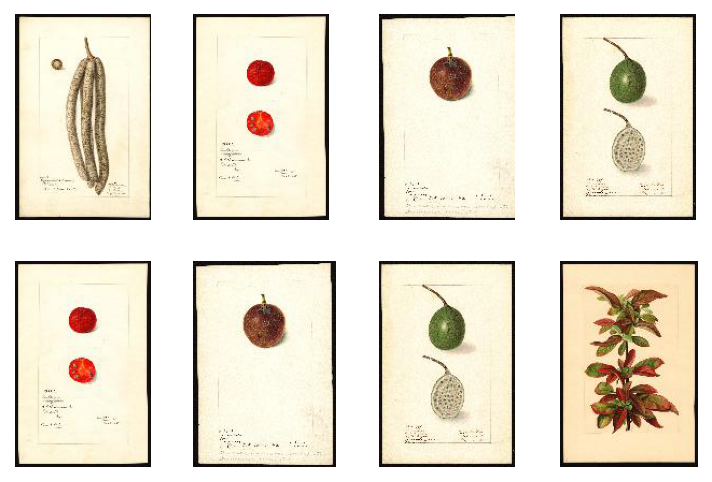

In [ ]:
plt.rcParams['figure.dpi'] = 150

unclassified_images = []
for value in unclassified:
  unclassified_images.append(np.array(Image.open('image-{0}.jpg'.format(value))))

fig, ax = plt.subplots(2, 4, sharex='col', sharey='row')
for i in range(2):
    for j in range(4):
      ax[i,j].axis("off")
      ax[i, j].imshow(unclassified_images[i+j])

In [ ]:
df[splits.apply(len)>1].head()

,Unnamed: 0,authors,fruit,image,painting_index,subjects,thumbnail_image,year
0,0,"Schutt, Ellen Isham, 1873-1955\n",Acca sellowiana,https://naldc-legacy.nal.usda.gov/pom/POM00007...,1,"Acca sellowiana , Acca",https://naldc-legacy.nal.usda.gov/pom/POM00007...,1909.0
1,0,"Schutt, Ellen Isham, 1873-1955\n",Acca sellowiana,https://naldc-legacy.nal.usda.gov/pom/POM00007...,2,"Acca sellowiana , Acca",https://naldc-legacy.nal.usda.gov/pom/POM00007...,1909.0
2,0,"Steadman, Royal Charles, b. 1875\n",Acca sellowiana,https://naldc-legacy.nal.usda.gov/pom/POM00007...,3,"Acca sellowiana , Acca",https://naldc-legacy.nal.usda.gov/pom/POM00007...,1919.0
3,0,"Newton, Amanda Almira, ca. 1860-1943\n",Acca sellowiana,https://naldc-legacy.nal.usda.gov/pom/POM00007...,4,"Acca sellowiana , Acca",https://naldc-legacy.nal.usda.gov/pom/POM00007...,1909.0
4,0,"Newton, Amanda Almira, ca. 1860-1943\n",Actinidia deliciosa,https://naldc-legacy.nal.usda.gov/pom/POM00007...,5,"Actinidia deliciosa , kiwifruit",https://naldc-legacy.nal.usda.gov/pom/POM00007...,1908.0


In [ ]:
df =df.join(splits, rsuffix='_list')

In [ ]:
splits2 = df[df.subjects_list.apply(len)>1].subjects_list.apply(lambda x: x[1])

In [ ]:
splits_list = splits2.value_counts()[splits2.value_counts() >32].index.tolist()

In [ ]:
spl_index = splits2[splits2.apply(lambda x: x in splits_list) == True].index.tolist()

In [ ]:
splits2[splits2.apply(lambda x: x in splits_list) == True]

106      oranges
107      oranges
126       lemons
127       lemons
128       lemons
          ...   
7571      grapes
7572      grapes
7573      grapes
7574      grapes
7575      grapes
Name: subjects_list, Length: 7048, dtype: object

In [ ]:
df = df.iloc[spl_index]

In [ ]:
df.drop(['subjects_list', 'Unnamed: 0','image','thumbnail_image','subjects'], inplace=True, axis =1)

In [ ]:
df.columns

Index(['authors', 'fruit', 'painting_index', 'year'], dtype='object')

In [ ]:
df = df.join(splits2[splits2.apply(lambda x: x in splits_list) == True])

In [ ]:
img_list = []
img_file_names = []
for i in range(len(spl_index)):
  img_file_names.append('image-{0}.png'.format(spl_index[i]))
  img_list.append(np.array(Image.open('image-{0}.jpg'.format(spl_index[i]))))

In [ ]:
df = df.join(pd.DataFrame(pd.Series(img_file_names, index=spl_index)))


In [ ]:
df.drop('file_name', inplace=True, axis=1)

In [ ]:
df.drop(['authors','fruit','painting_index','year'],axis=1,inplace=True)

In [ ]:
df.columns = ['label','file_name']

In [ ]:
df=df[['file_name','label']]

In [ ]:
dict_tmp = []
for i in range(len(df.label.unique().tolist())):
  dict_tmp.append((df.label.unique().tolist()[i],i))

In [ ]:
dict(dict_tmp)

{' apples': 5,
 ' avocados': 7,
 ' cherries': 8,
 ' grapefruits': 2,
 ' grapes': 12,
 ' lemons': 1,
 ' mangoes': 6,
 ' oranges': 0,
 ' peaches': 10,
 ' pears': 11,
 ' persimmons': 3,
 ' plums': 9,
 ' strawberries': 4}

In [ ]:
df['label'] = df['label'].astype('category')
df['label'] = df['label'].cat.rename_categories(dict(dict_tmp))

In [ ]:
df.head()

,file_name,label,0
106,image-106.jpg,0,image-106.png
107,image-107.jpg,0,image-107.png
126,image-126.jpg,1,image-126.png
127,image-127.jpg,1,image-127.png
128,image-128.jpg,1,image-128.png


We are in the process now of converting our dataframe with labels into a json that works with the stylegan2 model for conditional / labeled training - below is finishing that process.

In [ ]:
tmp_list = []
for i in range(df.shape[0]):
  tmp_list.append([df.iloc[i].file_name,df.iloc[i].label])


In [ ]:
tmp = [tmp_list]
dataset = pd.Series(tmp)
dataset.name = 'labels'

In [ ]:
dataset.index = ['labels']

In [ ]:
dataset.to_json()

'{"labels":[["image-106.png",0],["image-107.png",0],["image-126.png",1],["image-127.png",1],["image-128.png",1],["image-129.png",1],["image-130.png",1],["image-131.png",1],["image-132.png",1],["image-133.png",1],["image-134.png",1],["image-135.png",1],["image-136.png",1],["image-137.png",1],["image-138.png",1],["image-139.png",1],["image-140.png",1],["image-141.png",1],["image-142.png",1],["image-143.png",1],["image-144.png",1],["image-145.png",1],["image-146.png",1],["image-147.png",1],["image-148.png",1],["image-149.png",1],["image-150.png",1],["image-151.png",1],["image-152.png",1],["image-153.png",1],["image-154.png",1],["image-155.png",1],["image-156.png",1],["image-157.png",1],["image-158.png",1],["image-159.png",1],["image-160.png",1],["image-161.png",1],["image-162.png",1],["image-163.png",1],["image-164.png",1],["image-165.png",1],["image-166.png",1],["image-167.png",1],["image-168.png",1],["image-169.png",1],["image-170.png",1],["image-171.png",1],["image-172.png",1],["image-

In [ ]:
dataset.shape[0]

1

In [ ]:
counter = range(len(tmp_list))
str_tmp = []
k_tmp = []
file_tmp = []
for i in counter:
  str_tmp.append("%08d" % i)
  k_tmp.append("%05d" % int(i/1000))

for i in counter:
  file_tmp.append("{0}/img{1}.png".format(k_tmp[i],str_tmp[i]))
  

In [ ]:
tmp_list2 = []
for i in range(df.shape[0]):
  tmp_list2.append([file_tmp[i],df.iloc[i].label])

In [ ]:
tmp = [tmp_list2]
dataset = pd.Series(tmp)
dataset.name = 'labels'
dataset.index = ['labels']



In [ ]:
dataset.to_json()

'{"labels":[["00000\\/img00000000.png",0],["00000\\/img00000001.png",0],["00000\\/img00000002.png",1],["00000\\/img00000003.png",1],["00000\\/img00000004.png",1],["00000\\/img00000005.png",1],["00000\\/img00000006.png",1],["00000\\/img00000007.png",1],["00000\\/img00000008.png",1],["00000\\/img00000009.png",1],["00000\\/img00000010.png",1],["00000\\/img00000011.png",1],["00000\\/img00000012.png",1],["00000\\/img00000013.png",1],["00000\\/img00000014.png",1],["00000\\/img00000015.png",1],["00000\\/img00000016.png",1],["00000\\/img00000017.png",1],["00000\\/img00000018.png",1],["00000\\/img00000019.png",1],["00000\\/img00000020.png",1],["00000\\/img00000021.png",1],["00000\\/img00000022.png",1],["00000\\/img00000023.png",1],["00000\\/img00000024.png",1],["00000\\/img00000025.png",1],["00000\\/img00000026.png",1],["00000\\/img00000027.png",1],["00000\\/img00000028.png",1],["00000\\/img00000029.png",1],["00000\\/img00000030.png",1],["00000\\/img00000031.png",1],["00000\\/img00000032.png",1

In [ ]:
dict_tmp2 = []
for i in counter:
  dict_tmp2.append([df.iloc[i].file_name,"img{0}.png".format(str_tmp[i])])

In [ ]:
for key, value in dict(dict_tmp2).items():
        if os.path.exists(key):
            os.rename(key,value)

In [ ]:
ls

00000/  00001/  00002/  00003/  00004/  00005/  00006/  00007/  dataset.json


#Stylegan2

## Manipulating the images using a commandline tool to put them into the format that the model can process.

The model can take only square images that are width/height a power of 2 - I previously used them as 256x256 images, but the training time would be lower at 128x128 - below I installed imagemagick's unix standalone command line tool, made it executable and then did the conversion in size and to pngs (from jpgs) that the model requires. This takes about 10 minutes.

In [ ]:
cd /content/USDA_Pomological_Watercolors/data/images/

/content/USDA_Pomological_Watercolors/data/images


In [ ]:
!mkdir pngs

In [ ]:
!wget https://download.imagemagick.org/ImageMagick/download/binaries/magick

--2022-04-01 19:28:09--  https://download.imagemagick.org/ImageMagick/download/binaries/magick
Resolving download.imagemagick.org (download.imagemagick.org)... 50.251.58.13
Connecting to download.imagemagick.org (download.imagemagick.org)|50.251.58.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27104448 (26M)
Saving to: ‘magick’

magick              100%[===================>]  25.85M  2.34MB/s    in 22s     

2022-04-01 19:28:32 (1.17 MB/s) - ‘magick’ saved [27104448/27104448]



In [ ]:
!chmod +x magick

In [ ]:
!./magick '*.jpg[256x256!]' image-%03d.png

In [ ]:
import os
import shutil
src = '/content/USDA_Pomological_Watercolors/data/images'
dest = '/content/USDA_Pomological_Watercolors/data/images/pngs'
src_files = os.listdir(src)
for file_name in df.file_name.tolist():
  shutil.copy(file_name, dest)

In [ ]:
import sys

print('saving the dataset labels to a json called dataset.json')

original_stdout = sys.stdout # Save a reference to the original standard output

with open('dataset.json', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(dataset.to_json())
    sys.stdout = original_stdout # Reset the standard output to its original value

saving the dataset labels to a json called dataset.json


In [ ]:
#Here you can adjust the paths to your own specficiations - note down where you are working you will need it later.
!mkdir /content/drive/MyDrive/datascience/poms/pngs_labeled

In [ ]:
!mv /content/USDA_Pomological_Watercolors/data/images/pngs/*.* /content/drive/MyDrive/datascience/poms/pngs_labeled/

## Configuring the dataset and the model

We run our newly minted pngs through their data preparation script to produce a viable zip file of pngs, in our case, in this instance, without labels.

Then we are ready to run the model - with small numbers of steps between savings and for a short-ish length. This will be a fresh training, with the step below to execute for a continuation/resumation of the training at a later time.

This requires us to manipulate two of the configuration files to enable later versions of pytorch beyond what they're expecting, and to install packages to allow them to perform image manipulations every iteration of their model.

In [ ]:
cd /content/stylegan2-ada-pytorch/

/content/stylegan2-ada-pytorch


In [ ]:
!python dataset_tool.py --help

Usage: dataset_tool.py [OPTIONS]

  Convert an image dataset into a dataset
  archive usable with StyleGAN2 ADA PyTorch.

  The input dataset format is guessed from the
  --source argument:

  --source *_lmdb/                    Load LSUN dataset
  --source cifar-10-python.tar.gz     Load CIFAR-10 dataset
  --source train-images-idx3-ubyte.gz Load MNIST dataset
  --source path/                      Recursively load all images from path/
  --source dataset.zip                Recursively load all images from dataset.zip

  Specifying the output format and path:

  --dest /path/to/dir                 Save output files under /path/to/dir
  --dest /path/to/dataset.zip         Save output files into /path/to/dataset.zip

  The output dataset format can be either an
  image folder or an uncompressed zip archive.
  Zip archives makes it easier to move datasets
  around file servers and clusters, and may
  offer better training performance on network
  file systems.

  Images within the dataset

In [ ]:
#You must adjust the path to the pngs you created previously.
!python dataset_tool.py --source /content/drive/MyDrive/datascience/poms/pngs_labeled/ --dest /content/drive/MyDrive/datascience/poms/data_pngs_labeled.zip

100% 7048/7048 [32:55<00:00,  3.57it/s]


## Training setup

In [ ]:
!python train.py --help

Usage: train.py [OPTIONS]

  Train a GAN using the techniques described in
  the paper "Training Generative Adversarial
  Networks with Limited Data".

  Examples:

  # Train with custom dataset using 1 GPU.
  python train.py --outdir=~/training-runs --data=~/mydataset.zip --gpus=1

  # Train class-conditional CIFAR-10 using 2 GPUs.
  python train.py --outdir=~/training-runs --data=~/datasets/cifar10.zip \
      --gpus=2 --cfg=cifar --cond=1

  # Transfer learn MetFaces from FFHQ using 4 GPUs.
  python train.py --outdir=~/training-runs --data=~/datasets/metfaces.zip \
      --gpus=4 --cfg=paper1024 --mirror=1 --resume=ffhq1024 --snap=10

  # Reproduce original StyleGAN2 config F.
  python train.py --outdir=~/training-runs --data=~/datasets/ffhq.zip \
      --gpus=8 --cfg=stylegan2 --mirror=1 --aug=noaug

  Base configs (--cfg):
    auto       Automatically select reasonable defaults based on resolution
               and GPU count. Good starting point for new datasets.
    stylegan2  R

In [ ]:
#again, make a new directory to store the output - this is mine.
!mkdir /content/drive/MyDrive/datascience/poms/sgtrain_labeled_small/

In [ ]:
# these are the packages required - ninja is particularly important for their custom image manipulation libaries. 
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

     |████████████████████████████████| 195 kB 5.0 MB/s 
     |████████████████████████████████| 108 kB 88.9 MB/s 
     |████████████████████████████████| 26.9 MB 1.2 MB/s 


In [ ]:
#To train fresh, remove the --resume path. On the high ram/gpu colab pro machine (p100 gpu) this particular training routine took ~3m30/tick, ~10m for a scoring tick and the entire thing lasted 5h8mm.
!python train.py  --outdir /content/drive/MyDrive/datascience/poms/sgtrain_labeled_small/ --data /content/drive/MyDrive/datascience/poms/data_pngs_labeled.zip --gpus 1 --kimg 300 --snap 15 --cond True


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 15,
  "network_snapshot_ticks": 15,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/datascience/poms/data_pngs_labeled.zip",
    "use_labels": true,
    "max_size": 7048,
    "xflip": false,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 256,
    "w_dim": 256,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 256,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel

In [ ]:
#To train fresh, remove the --resume path. On the high ram/gpu colab pro machine (p100 gpu) this particular training routine took ~4m/tick, ~8m for a scoring tick and the entire thing lasted 6h49m.
!python train.py --resume /content/drive/MyDrive/datascience/poms/sgtrain_labeled_small/00000-data_pngs_labeled-cond-auto1-kimg300/network-snapshot-000300.pkl --outdir /content/drive/MyDrive/datascience/poms/sgtrain_labeled_small/ --data /content/drive/MyDrive/datascience/poms/data_pngs_labeled.zip --gpus 1 --kimg 360 --snap 15 --cond True


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 15,
  "network_snapshot_ticks": 15,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/datascience/poms/data_pngs_labeled.zip",
    "use_labels": true,
    "max_size": 7048,
    "xflip": false,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 256,
    "w_dim": 256,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 256,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel

In [ ]:
cd /content/stylegan2-ada-pytorch/stylegan2-ada-pytorch/

/content/stylegan2-ada-pytorch/stylegan2-ada-pytorch


Below is testing the json file produced earlier has the correct output - this code appears in dataset.py from the stylegan2 implementation - so seeing it output correctly is part of troubleshooting.

In [ ]:
import json
# Load labels.
labels = {}
meta_fname = os.path.join('/content/drive/MyDrive/datascience/poms/pngs_labeled', 'dataset.json')
if os.path.isfile(meta_fname):
    with open(meta_fname, 'r') as file:
        labels = json.load(file)['labels']
        if labels is not None:
            labels = { x[0]: x[1] for x in labels }
        else:
            labels = {}

In [ ]:
labels

{'00000/img00000000.png': 0,
 '00000/img00000001.png': 0,
 '00000/img00000002.png': 1,
 '00000/img00000003.png': 1,
 '00000/img00000004.png': 1,
 '00000/img00000005.png': 1,
 '00000/img00000006.png': 1,
 '00000/img00000007.png': 1,
 '00000/img00000008.png': 1,
 '00000/img00000009.png': 1,
 '00000/img00000010.png': 1,
 '00000/img00000011.png': 1,
 '00000/img00000012.png': 1,
 '00000/img00000013.png': 1,
 '00000/img00000014.png': 1,
 '00000/img00000015.png': 1,
 '00000/img00000016.png': 1,
 '00000/img00000017.png': 1,
 '00000/img00000018.png': 1,
 '00000/img00000019.png': 1,
 '00000/img00000020.png': 1,
 '00000/img00000021.png': 1,
 '00000/img00000022.png': 1,
 '00000/img00000023.png': 1,
 '00000/img00000024.png': 1,
 '00000/img00000025.png': 1,
 '00000/img00000026.png': 1,
 '00000/img00000027.png': 1,
 '00000/img00000028.png': 1,
 '00000/img00000029.png': 1,
 '00000/img00000030.png': 1,
 '00000/img00000031.png': 1,
 '00000/img00000032.png': 1,
 '00000/img00000033.png': 1,
 '00000/img000